In [ ]:
!pip install tensorflow
!pip install keras

In [358]:
# import the required packages
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from matplotlib import rcParams
import os
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score
from tensorflow import keras
from keras.layers import Input, Embedding, Dot, Flatten, Dense
from keras.models import Model
from keras.optimizers import Adam
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from tqdm import tqdm
import re
from google.colab import drive

In [ ]:
drive.mount('/content/drive')
# read the csv file from drive
data=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/zomato.csv')

In [253]:
# Fetch first five rows
data.head()

url  \
0  https://www.zomato.com/bangalore/jalsa-banasha...   
1  https://www.zomato.com/bangalore/spice-elephan...   
2  https://www.zomato.com/SanchurroBangalore?cont...   
3  https://www.zomato.com/bangalore/addhuri-udupi...   
4  https://www.zomato.com/bangalore/grand-village...   

                                             address                   name  \
0  942, 21st Main Road, 2nd Stage, Banashankari, ...                  Jalsa   
1  2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...         Spice Elephant   
2  1112, Next to KIMS Medical College, 17th Cross...        San Churro Cafe   
3  1st Floor, Annakuteera, 3rd Stage, Banashankar...  Addhuri Udupi Bhojana   
4  10, 3rd Floor, Lakshmi Associates, Gandhi Baza...          Grand Village   

  online_order book_table   rate  votes                             phone  \
0          Yes        Yes  4.1/5    775    080 42297555\r\n+91 9743772233   
1          Yes         No  4.1/5    787                      080 41714161   
2          Yes         No  3.8/5    918                    +91 9663487993   
3           No         No  3.7/5     88                    +91 9620009302   
4           No         No  3.8/5    166  +91 8026612447\r\n+91 9901210005   

       location            rest_type  \
0  Banashankari        Casual Dining   
1  Banashankari        Casual Dining   
2  Banashankari  Cafe, Casual Dining   
3  Banashankari          Quick Bites   
4  Basavanagudi        Casual Dining   

                                          dish_liked  \
0  Pasta, Lunch Buffet, Masala Papad, Paneer Laja...   
1  Momos, Lunch Buffet, Chocolate Nirvana, Thai G...   
2  Churros, Cannelloni, Minestrone Soup, Hot Choc...   
3                                        Masala Dosa   
4                                Panipuri, Gol Gappe   

                         cuisines approx_cost(for two people)  \
0  North Indian, Mughlai, Chinese                         800   
1     Chinese, North Indian, Thai                         800   
2          Cafe, Mexican, Italian                         800   
3      South Indian, North Indian                         300   
4        North Indian, Rajasthani                         600   

                                        reviews_list menu_item  \
0  [('Rated 4.0', 'RATED\n  A beautiful place to ...        []   
1  [('Rated 4.0', 'RATED\n  Had been here for din...        []   
2  [('Rated 3.0', "RATED\n  Ambience is not that ...        []   
3  [('Rated 4.0', "RATED\n  Great food and proper...        []   
4  [('Rated 4.0', 'RATED\n  Very good restaurant ...        []   

  listed_in(type) listed_in(city)  
0          Buffet    Banashankari  
1          Buffet    Banashankari  
2          Buffet    Banashankari  
3          Buffet    Banashankari  
4          Buffet    Banashankari

In [254]:
# Cleaning Step 1: renaming columns
data = data.rename(columns = {'listed_in(type)':'food_type', 'listed_in(city)':'city','approx_cost(for two people)':'cost for two'})

In [255]:
# display columns
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51717 entries, 0 to 51716
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   url           51717 non-null  object
 1   address       51717 non-null  object
 2   name          51717 non-null  object
 3   online_order  51717 non-null  object
 4   book_table    51717 non-null  object
 5   rate          43942 non-null  object
 6   votes         51717 non-null  int64 
 7   phone         50509 non-null  object
 8   location      51696 non-null  object
 9   rest_type     51490 non-null  object
 10  dish_liked    23639 non-null  object
 11  cuisines      51672 non-null  object
 12  cost for two  51371 non-null  object
 13  reviews_list  51717 non-null  object
 14  menu_item     51717 non-null  object
 15  food_type     51717 non-null  object
 16  city          51717 non-null  object
dtypes: int64(1), object(16)
memory usage: 6.7+ MB


In [256]:
# Report the percentage of missing values per column
data_length = len(data)
sum_null_values = data.isnull().sum()
percent_missing = sum_null_values * 100 / data_length
missing_value_data = pd.DataFrame({'column_name': data.columns,
                                 'percent_missing': percent_missing})

In [257]:
print(missing_value_data)

               column_name  percent_missing
url                    url         0.000000
address            address         0.000000
name                  name         0.000000
online_order  online_order         0.000000
book_table      book_table         0.000000
rate                  rate        15.033741
votes                votes         0.000000
phone                phone         2.335789
location          location         0.040606
rest_type        rest_type         0.438927
dish_liked      dish_liked        54.291626
cuisines          cuisines         0.087012
cost for two  cost for two         0.669026
reviews_list  reviews_list         0.000000
menu_item        menu_item         0.000000
food_type        food_type         0.000000
city                  city         0.000000


In [258]:
# Cleaning Step 2: Dropping columns with > 50% null rows
for index, row in missing_value_data.iterrows():
  if row['percent_missing'] > 50:
    del data[row['column_name']]    

In [259]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51717 entries, 0 to 51716
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   url           51717 non-null  object
 1   address       51717 non-null  object
 2   name          51717 non-null  object
 3   online_order  51717 non-null  object
 4   book_table    51717 non-null  object
 5   rate          43942 non-null  object
 6   votes         51717 non-null  int64 
 7   phone         50509 non-null  object
 8   location      51696 non-null  object
 9   rest_type     51490 non-null  object
 10  cuisines      51672 non-null  object
 11  cost for two  51371 non-null  object
 12  reviews_list  51717 non-null  object
 13  menu_item     51717 non-null  object
 14  food_type     51717 non-null  object
 15  city          51717 non-null  object
dtypes: int64(1), object(15)
memory usage: 6.3+ MB


In [260]:
data['rate'].unique()

array(['4.1/5', '3.8/5', '3.7/5', '3.6/5', '4.6/5', '4.0/5', '4.2/5',
       '3.9/5', '3.1/5', '3.0/5', '3.2/5', '3.3/5', '2.8/5', '4.4/5',
       '4.3/5', 'NEW', '2.9/5', '3.5/5', nan, '2.6/5', '3.8 /5', '3.4/5',
       '4.5/5', '2.5/5', '2.7/5', '4.7/5', '2.4/5', '2.2/5', '2.3/5',
       '3.4 /5', '-', '3.6 /5', '4.8/5', '3.9 /5', '4.2 /5', '4.0 /5',
       '4.1 /5', '3.7 /5', '3.1 /5', '2.9 /5', '3.3 /5', '2.8 /5',
       '3.5 /5', '2.7 /5', '2.5 /5', '3.2 /5', '2.6 /5', '4.5 /5',
       '4.3 /5', '4.4 /5', '4.9/5', '2.1/5', '2.0/5', '1.8/5', '4.6 /5',
       '4.9 /5', '3.0 /5', '4.8 /5', '2.3 /5', '4.7 /5', '2.4 /5',
       '2.1 /5', '2.2 /5', '2.0 /5', '1.8 /5'], dtype=object)

In [261]:
# Cleaning Step 3: Handling invalid values with nan
data.rate = data.rate.replace("NEW", np.nan).replace("-", np.nan).replace(' ', '')

In [262]:
data['rate'].unique()

array(['4.1/5', '3.8/5', '3.7/5', '3.6/5', '4.6/5', '4.0/5', '4.2/5',
       '3.9/5', '3.1/5', '3.0/5', '3.2/5', '3.3/5', '2.8/5', '4.4/5',
       '4.3/5', nan, '2.9/5', '3.5/5', '2.6/5', '3.8 /5', '3.4/5',
       '4.5/5', '2.5/5', '2.7/5', '4.7/5', '2.4/5', '2.2/5', '2.3/5',
       '3.4 /5', '3.6 /5', '4.8/5', '3.9 /5', '4.2 /5', '4.0 /5',
       '4.1 /5', '3.7 /5', '3.1 /5', '2.9 /5', '3.3 /5', '2.8 /5',
       '3.5 /5', '2.7 /5', '2.5 /5', '3.2 /5', '2.6 /5', '4.5 /5',
       '4.3 /5', '4.4 /5', '4.9/5', '2.1/5', '2.0/5', '1.8/5', '4.6 /5',
       '4.9 /5', '3.0 /5', '4.8 /5', '2.3 /5', '4.7 /5', '2.4 /5',
       '2.1 /5', '2.2 /5', '2.0 /5', '1.8 /5'], dtype=object)

In [263]:
# Cleaning Step 4: Changing data type of columns
data.rate = data.rate.str.split('/').str[0]
data['rate'] = data.rate.astype(float)

In [264]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51717 entries, 0 to 51716
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   url           51717 non-null  object 
 1   address       51717 non-null  object 
 2   name          51717 non-null  object 
 3   online_order  51717 non-null  object 
 4   book_table    51717 non-null  object 
 5   rate          41665 non-null  float64
 6   votes         51717 non-null  int64  
 7   phone         50509 non-null  object 
 8   location      51696 non-null  object 
 9   rest_type     51490 non-null  object 
 10  cuisines      51672 non-null  object 
 11  cost for two  51371 non-null  object 
 12  reviews_list  51717 non-null  object 
 13  menu_item     51717 non-null  object 
 14  food_type     51717 non-null  object 
 15  city          51717 non-null  object 
dtypes: float64(1), int64(1), object(14)
memory usage: 6.3+ MB


In [265]:
# Cleaning Step 5: Filling null values of rate with mean rating
mean_value = data["rate"].mean() 
data["rate"].fillna(mean_value,inplace=True)

In [266]:
data['rate'].unique()

array([4.1       , 3.8       , 3.7       , 3.6       , 4.6       ,
       4.        , 4.2       , 3.9       , 3.1       , 3.        ,
       3.2       , 3.3       , 2.8       , 4.4       , 4.3       ,
       3.70044882, 2.9       , 3.5       , 2.6       , 3.4       ,
       4.5       , 2.5       , 2.7       , 4.7       , 2.4       ,
       2.2       , 2.3       , 4.8       , 4.9       , 2.1       ,
       2.        , 1.8       ])

In [267]:
# Cleaning Step 6: Drop rows with Null values
data.dropna(inplace = True)
data.shape


(50279, 16)

In [268]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50279 entries, 0 to 51716
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   url           50279 non-null  object 
 1   address       50279 non-null  object 
 2   name          50279 non-null  object 
 3   online_order  50279 non-null  object 
 4   book_table    50279 non-null  object 
 5   rate          50279 non-null  float64
 6   votes         50279 non-null  int64  
 7   phone         50279 non-null  object 
 8   location      50279 non-null  object 
 9   rest_type     50279 non-null  object 
 10  cuisines      50279 non-null  object 
 11  cost for two  50279 non-null  object 
 12  reviews_list  50279 non-null  object 
 13  menu_item     50279 non-null  object 
 14  food_type     50279 non-null  object 
 15  city          50279 non-null  object 
dtypes: float64(1), int64(1), object(14)
memory usage: 6.5+ MB


In [269]:
# Cleaning Step 7: Remove special characters
data = data.replace(r'\r\n',' ', regex=True)
data = data.replace(r'\n',' ', regex=True)

In [270]:
data.head()

url  \
0  https://www.zomato.com/bangalore/jalsa-banasha...   
1  https://www.zomato.com/bangalore/spice-elephan...   
2  https://www.zomato.com/SanchurroBangalore?cont...   
3  https://www.zomato.com/bangalore/addhuri-udupi...   
4  https://www.zomato.com/bangalore/grand-village...   

                                             address                   name  \
0  942, 21st Main Road, 2nd Stage, Banashankari, ...                  Jalsa   
1  2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...         Spice Elephant   
2  1112, Next to KIMS Medical College, 17th Cross...        San Churro Cafe   
3  1st Floor, Annakuteera, 3rd Stage, Banashankar...  Addhuri Udupi Bhojana   
4  10, 3rd Floor, Lakshmi Associates, Gandhi Baza...          Grand Village   

  online_order book_table  rate  votes                          phone  \
0          Yes        Yes   4.1    775    080 42297555 +91 9743772233   
1          Yes         No   4.1    787                   080 41714161   
2          Yes         No   3.8    918                 +91 9663487993   
3           No         No   3.7     88                 +91 9620009302   
4           No         No   3.8    166  +91 8026612447 +91 9901210005   

       location            rest_type                        cuisines  \
0  Banashankari        Casual Dining  North Indian, Mughlai, Chinese   
1  Banashankari        Casual Dining     Chinese, North Indian, Thai   
2  Banashankari  Cafe, Casual Dining          Cafe, Mexican, Italian   
3  Banashankari          Quick Bites      South Indian, North Indian   
4  Basavanagudi        Casual Dining        North Indian, Rajasthani   

  cost for two                                       reviews_list menu_item  \
0          800  [('Rated 4.0', 'RATED\n  A beautiful place to ...        []   
1          800  [('Rated 4.0', 'RATED\n  Had been here for din...        []   
2          800  [('Rated 3.0', "RATED\n  Ambience is not that ...        []   
3          300  [('Rated 4.0', "RATED\n  Great food and proper...        []   
4          600  [('Rated 4.0', 'RATED\n  Very good restaurant ...        []   

  food_type          city  
0    Buffet  Banashankari  
1    Buffet  Banashankari  
2    Buffet  Banashankari  
3    Buffet  Banashankari  
4    Buffet  Banashankari

In [271]:
data.head().dtypes

url              object
address          object
name             object
online_order     object
book_table       object
rate            float64
votes             int64
phone            object
location         object
rest_type        object
cuisines         object
cost for two     object
reviews_list     object
menu_item        object
food_type        object
city             object
dtype: object

In [272]:
data["phone"][4]

'+91 8026612447 +91 9901210005'

In [273]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [274]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [275]:
from nltk.corpus import stopwords

In [276]:
stop = stopwords.words('english')
# Cleaning Step 8: Stop Words Removal
check_add = []
for add in data["address"]:
  flag = 0
  for word in add.split():
    if word in stop:
      flag = 1
      check_add.append(add)
      break

  # checking for just 1 address with stop word
  if flag == 1:
    break
print(check_add)
data["address"] = data["address"].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

['1112, Next to KIMS Medical College, 17th Cross, 2nd Stage, Banashankari, Bangalore']


In [277]:
data.head()

url  \
0  https://www.zomato.com/bangalore/jalsa-banasha...   
1  https://www.zomato.com/bangalore/spice-elephan...   
2  https://www.zomato.com/SanchurroBangalore?cont...   
3  https://www.zomato.com/bangalore/addhuri-udupi...   
4  https://www.zomato.com/bangalore/grand-village...   

                                             address                   name  \
0  942, 21st Main Road, 2nd Stage, Banashankari, ...                  Jalsa   
1  2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...         Spice Elephant   
2  1112, Next KIMS Medical College, 17th Cross, 2...        San Churro Cafe   
3  1st Floor, Annakuteera, 3rd Stage, Banashankar...  Addhuri Udupi Bhojana   
4  10, 3rd Floor, Lakshmi Associates, Gandhi Baza...          Grand Village   

  online_order book_table  rate  votes                          phone  \
0          Yes        Yes   4.1    775    080 42297555 +91 9743772233   
1          Yes         No   4.1    787                   080 41714161   
2          Yes         No   3.8    918                 +91 9663487993   
3           No         No   3.7     88                 +91 9620009302   
4           No         No   3.8    166  +91 8026612447 +91 9901210005   

       location            rest_type                        cuisines  \
0  Banashankari        Casual Dining  North Indian, Mughlai, Chinese   
1  Banashankari        Casual Dining     Chinese, North Indian, Thai   
2  Banashankari  Cafe, Casual Dining          Cafe, Mexican, Italian   
3  Banashankari          Quick Bites      South Indian, North Indian   
4  Basavanagudi        Casual Dining        North Indian, Rajasthani   

  cost for two                                       reviews_list menu_item  \
0          800  [('Rated 4.0', 'RATED\n  A beautiful place to ...        []   
1          800  [('Rated 4.0', 'RATED\n  Had been here for din...        []   
2          800  [('Rated 3.0', "RATED\n  Ambience is not that ...        []   
3          300  [('Rated 4.0', "RATED\n  Great food and proper...        []   
4          600  [('Rated 4.0', 'RATED\n  Very good restaurant ...        []   

  food_type          city  
0    Buffet  Banashankari  
1    Buffet  Banashankari  
2    Buffet  Banashankari  
3    Buffet  Banashankari  
4    Buffet  Banashankari

In [278]:
# Cleaning Step 9: Remove duplicate rows

data = data.drop_duplicates()

In [279]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50279 entries, 0 to 51716
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   url           50279 non-null  object 
 1   address       50279 non-null  object 
 2   name          50279 non-null  object 
 3   online_order  50279 non-null  object 
 4   book_table    50279 non-null  object 
 5   rate          50279 non-null  float64
 6   votes         50279 non-null  int64  
 7   phone         50279 non-null  object 
 8   location      50279 non-null  object 
 9   rest_type     50279 non-null  object 
 10  cuisines      50279 non-null  object 
 11  cost for two  50279 non-null  object 
 12  reviews_list  50279 non-null  object 
 13  menu_item     50279 non-null  object 
 14  food_type     50279 non-null  object 
 15  city          50279 non-null  object 
dtypes: float64(1), int64(1), object(14)
memory usage: 6.5+ MB


In [280]:
# Cleaning Step 10: Stemming
from nltk.stem import WordNetLemmatizer, PorterStemmer
stemmer = PorterStemmer()

def stemming(line):
  w = line.split()
  w = [stemmer.stem(wrd) for wrd in w]
  res = ' '.join(w)
  return res

data.reviews_list = data.reviews_list.apply(stemming)

In [281]:
data.head()

url  \
0  https://www.zomato.com/bangalore/jalsa-banasha...   
1  https://www.zomato.com/bangalore/spice-elephan...   
2  https://www.zomato.com/SanchurroBangalore?cont...   
3  https://www.zomato.com/bangalore/addhuri-udupi...   
4  https://www.zomato.com/bangalore/grand-village...   

                                             address                   name  \
0  942, 21st Main Road, 2nd Stage, Banashankari, ...                  Jalsa   
1  2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...         Spice Elephant   
2  1112, Next KIMS Medical College, 17th Cross, 2...        San Churro Cafe   
3  1st Floor, Annakuteera, 3rd Stage, Banashankar...  Addhuri Udupi Bhojana   
4  10, 3rd Floor, Lakshmi Associates, Gandhi Baza...          Grand Village   

  online_order book_table  rate  votes                          phone  \
0          Yes        Yes   4.1    775    080 42297555 +91 9743772233   
1          Yes         No   4.1    787                   080 41714161   
2          Yes         No   3.8    918                 +91 9663487993   
3           No         No   3.7     88                 +91 9620009302   
4           No         No   3.8    166  +91 8026612447 +91 9901210005   

       location            rest_type                        cuisines  \
0  Banashankari        Casual Dining  North Indian, Mughlai, Chinese   
1  Banashankari        Casual Dining     Chinese, North Indian, Thai   
2  Banashankari  Cafe, Casual Dining          Cafe, Mexican, Italian   
3  Banashankari          Quick Bites      South Indian, North Indian   
4  Basavanagudi        Casual Dining        North Indian, Rajasthani   

  cost for two                                       reviews_list menu_item  \
0          800  [('Rated 4.0', 'RATED\n  A beautiful place to ...        []   
1          800  [('Rated 4.0', 'RATED\n  Had been here for din...        []   
2          800  [('Rated 3.0', "RATED\n  Ambience is not that ...        []   
3          300  [('Rated 4.0', "RATED\n  Great food and proper...        []   
4          600  [('Rated 4.0', 'RATED\n  Very good restaurant ...        []   

  food_type          city  
0    Buffet  Banashankari  
1    Buffet  Banashankari  
2    Buffet  Banashankari  
3    Buffet  Banashankari  
4    Buffet  Banashankari

In [282]:
# EDA Step 1a
data.describe()

rate         votes
count  50279.000000  50279.000000
mean       3.702415    286.921975
std        0.395393    811.682706
min        1.800000      0.000000
25%        3.500000      7.000000
50%        3.700449     42.000000
75%        3.900000    201.000000
max        4.900000  16832.000000

In [283]:
#EDA Step 1b: Correlation Matrix
cols_to_use = ['rate', 'votes', 'cost for two']
subset = data[cols_to_use].copy() 
subset.loc[:, 'rate'] = pd.to_numeric(subset['rate'].astype(str).str.replace('[^\d.]', '', regex=True), errors='coerce', downcast='float') # set regex to True
subset.loc[:, 'cost for two'] = pd.to_numeric(subset['cost for two'].astype(str).str.replace('[^\d.]', '', regex=True), errors='coerce', downcast='integer') # set regex to True
subset.dropna(inplace=True)
corr_matrix = subset.corr()
print(corr_matrix)

                  rate     votes  cost for two
rate          1.000000  0.428601      0.366768
votes         0.428601  1.000000      0.380826
cost for two  0.366768  0.380826      1.000000


In [284]:
#EDA Step 2: Finding best restaurants in bengaluru
import plotly.express as px
def plot_top_restaurant_locations(data):
    """
    Plots the top 10 restaurants in Bangalore.

    Parameters: data (pandas.DataFrame) : The restaurant data with columns address and location.
    Returns: None
    """

    location_data = data.groupby(['address', 'location']).location.nunique().index.to_frame()
    top_locations = location_data['location'].value_counts()[:10]

    fig = px.bar(x=top_locations, 
                 y=top_locations.index, 
                 orientation='h', 
                 title='Best restaurant locations in Bengaluru',
                 labels={'x': 'Unique restaurants', 'y': 'Location'}, 
                 color=top_locations, 
                 color_continuous_scale='Blues'
                 )
    fig.update_layout(font=dict(size=14))
    fig.show()

In [285]:
plot_top_restaurant_locations(data)

In [286]:
#EDA Step 3: Analysis of Restaurant Count Vs. Rating bu Delivery Type
grouped_data = data.groupby(['rate', 'online_order']).size().reset_index(name='count')

fig = px.scatter(grouped_data, x='rate', y='count', color='online_order', size='count',
                 hover_data=['count'], title='Restaurant Count vs. Rating by Delivery Type')
fig.update_layout(xaxis_title='Rate', yaxis_title='Restaurant Count')
fig.show()

In [287]:
#EDA Step 4: Analysis of Restaurant Type and Rate
fig = px.box(data, x='rest_type', y='rate', 
             title='Restaurant Type and Rate',
             color_discrete_sequence=['#FF5733'],
             labels={'rest_type': 'Restaurant Type', 'rate': 'Rate'})
fig.update_layout(title_font=dict(size=28), legend=dict(font=dict(size=16)))

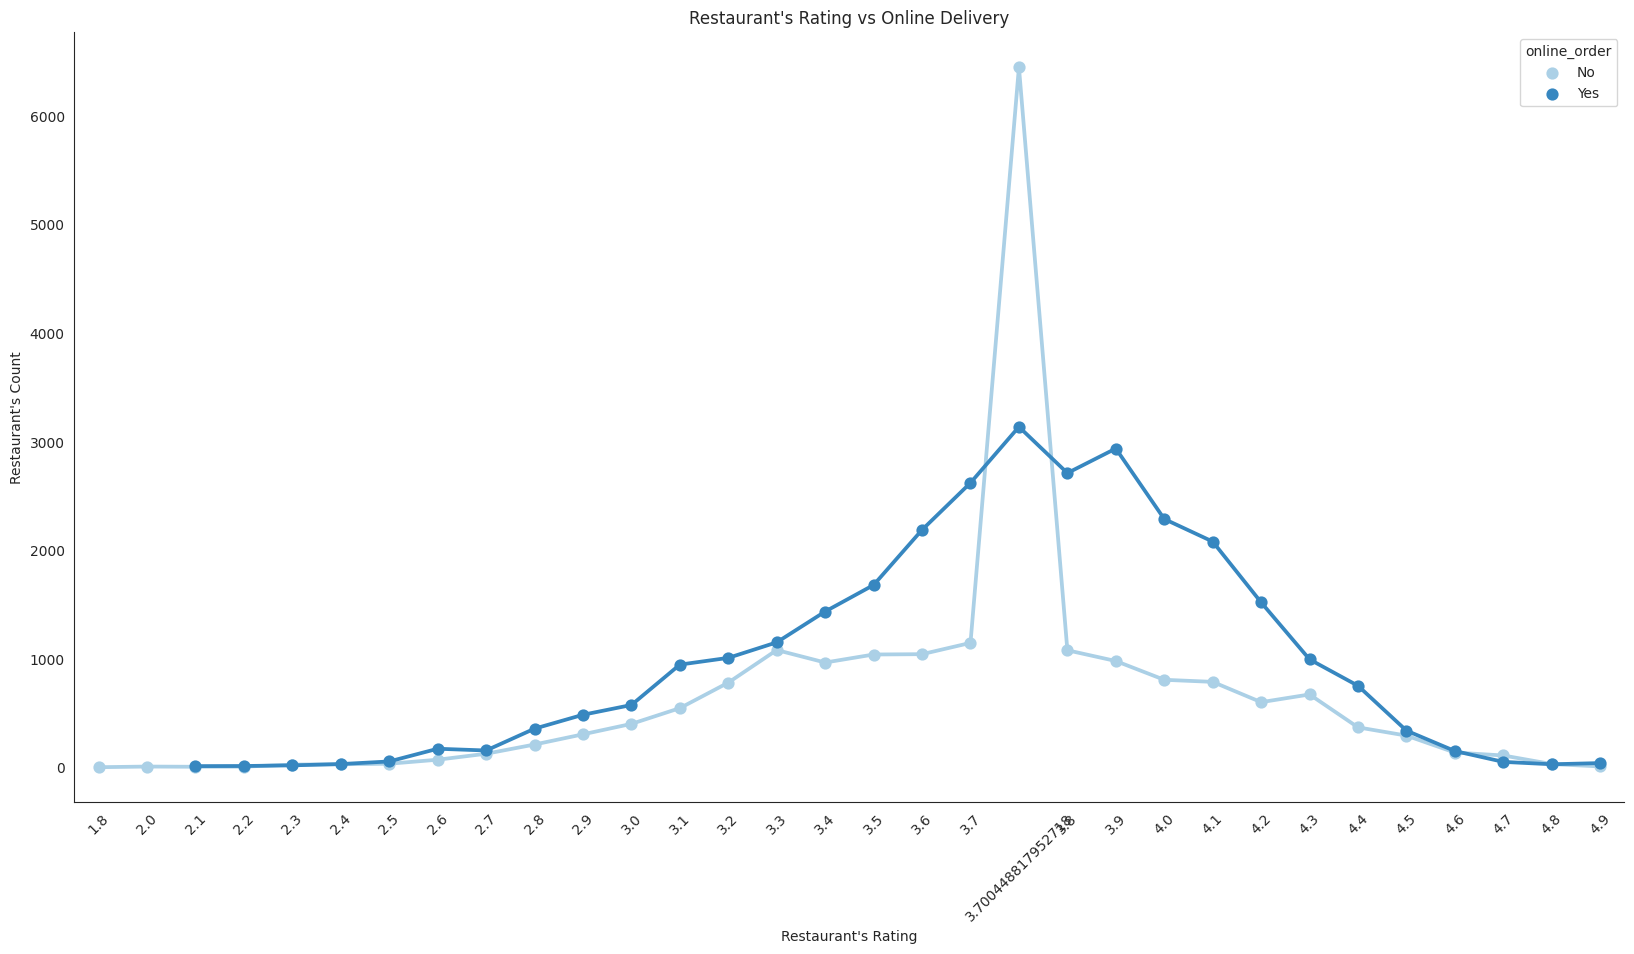

In [288]:
#EDA Step 5: Restaurant's Rating vs Online Delivery
plt.figure(figsize=(20, 10))
sns.set_style('white')

rating_data = data.groupby(['rate', 'online_order']).size().reset_index(name='count')


ax = sns.pointplot(x='rate', y='count', hue='online_order', data=rating_data, palette='Blues')

ax.set_title('Restaurant\'s Rating vs Online Delivery')
ax.set_xlabel('Restaurant\'s Rating')
ax.set_ylabel('Restaurant\'s Count')
sns.despine()
plt.xticks(rotation=45)
plt.show()

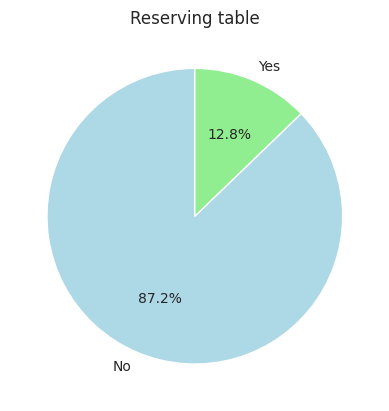

In [289]:
#EDA Step 6: Analysis of Book Table Distribution
column_counts = data['book_table'].value_counts()
labels = column_counts.index
sizes = column_counts.values
colors = ['lightblue', 'lightgreen']
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Reserving table')
plt.show()

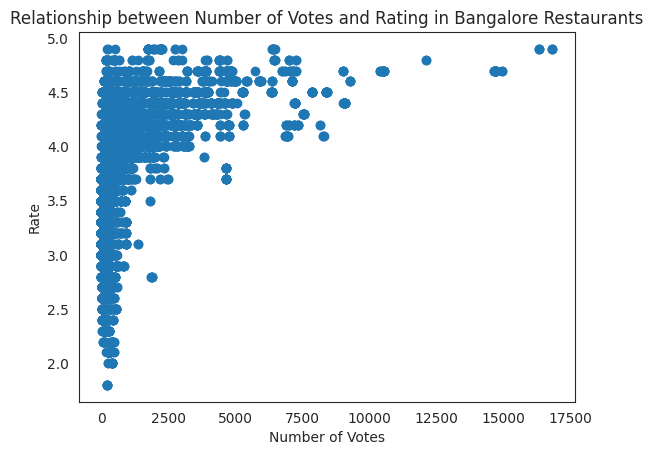

In [290]:
#EDA Step 7: Relationship between Number of Votes and Rating
plt.scatter(data['votes'], data['rate'])
# Add labels and a title to the plot
plt.xlabel('Number of Votes')
plt.ylabel('Rate')
plt.title('Relationship between Number of Votes and Rating in Bangalore Restaurants')
plt.show()

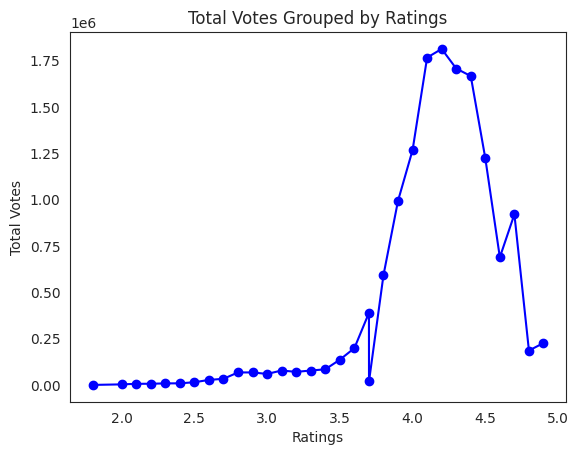

In [291]:
# EDA Step 8: Total Votes Grouped by Rating
votes_by_rating = data.groupby('rate')['votes'].sum()
plt.plot(votes_by_rating.index, votes_by_rating.values, 'bo-')
plt.xlabel('Ratings')
plt.ylabel('Total Votes')
plt.title('Total Votes Grouped by Ratings')
plt.show()

<ipython-input-292-7a69f76c9199>:4: FutureWarning:

The default value of regex will change from True to False in a future version.



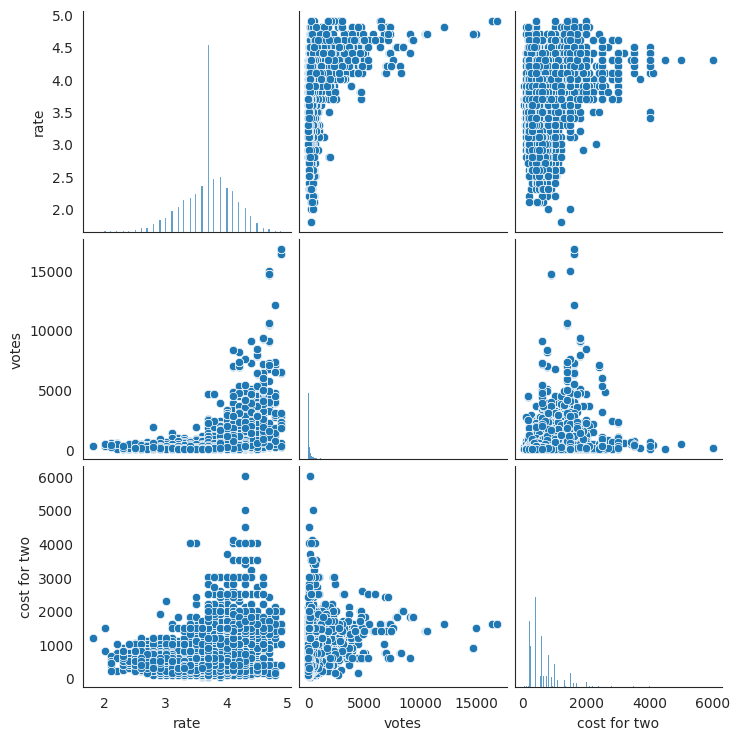

In [292]:
# EDA Step 9: Pair Plots
cols_to_use = ['rate', 'votes', 'cost for two']
data[cols_to_use] = data[cols_to_use].astype(str)
data[cols_to_use] = data[cols_to_use].apply(lambda x: pd.to_numeric(x.str.replace('[^\d.]', ''), errors='coerce'))
data.dropna(inplace=True)
sns.pairplot(data[cols_to_use])

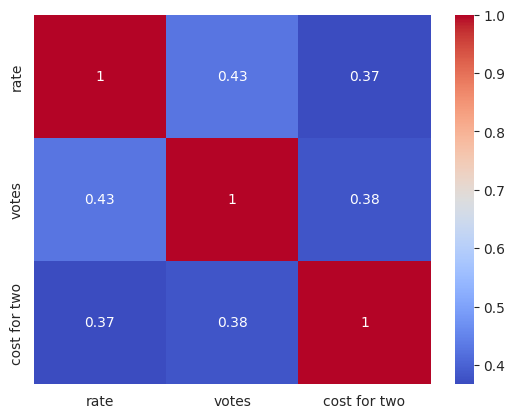

In [293]:
#EDA Step 9b: Heatmap
corr = data.corr()
sns.heatmap(corr, cmap='coolwarm', annot=True)
plt.show()

In [294]:
#EDA Step 10: Skewness
num_cols = data.select_dtypes(include=['int64', 'float64']).columns
skewness = data.skew()
print("Skewness values for numerical columns:")
print(skewness)

Skewness values for numerical columns:
rate           -0.365796
votes           7.513797
cost for two    2.595196
dtype: float64


<ipython-input-294-934313db6038>:3: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



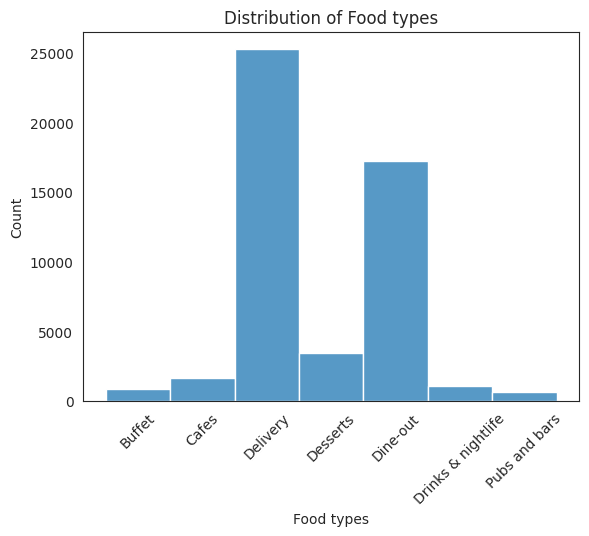

In [295]:
# EDA Step 11: Histogram plot for the distribution of food types
sns.histplot(data=data, x='food_type', bins=50, kde=False)

plt.title('Distribution of Food types')
plt.xlabel('Food types')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

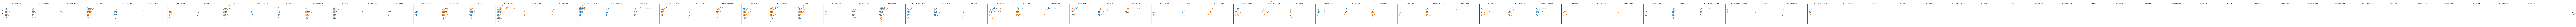

In [296]:
# EDA Step 12: Split plot for establishing the relationship between Approximate Cost for Two People, Rating, and Online Order by Location
sns.relplot(x='cost for two', y='rate', hue='online_order', col='location', data=data)
plt.subplots_adjust(top=0.85)
plt.suptitle('Relationship between Approximate Cost for Two People, Rating, and Online Order by Location')
plt.show()

In [297]:
# Pre-processing : Encoding of data
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
def Encode(data):
    for column in data.columns[~data.columns.isin(['rate', 'cost for two', 'votes'])]:
        data[column] = data[column].factorize()[0]
    return data

In [298]:
zomato_en = Encode(data.copy())

In [299]:
# Find the nearest cost value
def find_nearest_cost(data, cost_for_two):
    idx = (np.abs(data['cost for two'] - cost_for_two)).idxmin()
    nearest_row = data.loc[idx]
    return nearest_row['cost for two']

In [300]:
#1: Linear Regression
def recommend_location(df):

    X = df[['votes', 'cost for two', 'location']].values
    y = df['rate'].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # predictions on test dataset
    y_pred = model.predict(X_test)

    # evaluation metrics: mean squared error and r-squared score
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    max_votes = df['votes'].max()
    max_cost = df['cost for two'].max()
    possible_votes = np.linspace(0, max_votes, 101)
    possible_cost = np.linspace(0, max_cost, 101)
    locations = df['location'].unique()
    possible_locations = [(votes, cost, loc) for votes in possible_votes for cost in possible_cost for loc in locations]
    new_df = pd.DataFrame(possible_locations, columns=['votes', 'cost for two', 'location'])

    y_pred = model.predict(new_df[['votes', 'cost for two', 'location']].values)
    y_pred = np.clip(y_pred, a_min=None, a_max=5)
    new_df['predicted rating'] = y_pred
    best_location = new_df.loc[new_df['predicted rating'].idxmax()]

    # 3D scatter plot
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(projection='3d')
    ax.scatter(new_df['votes'], new_df['cost for two'], new_df['predicted rating'], c='b', alpha=0.5)
    ax.scatter(best_location['votes'], best_location['cost for two'], best_location['predicted rating'], c='r', marker='*', s=300)
    ax.set_xlabel('Votes')
    ax.set_ylabel('Cost for Two')
    ax.set_zlabel('Predicted Rating')
    plt.title('Predicted Ratings for all Locations')
    plt.show()

    return ("Model accuracy: MSE = {}, R-squared = {}".format(mse, r2), best_location['votes'], best_location['cost for two'], best_location['predicted rating'])

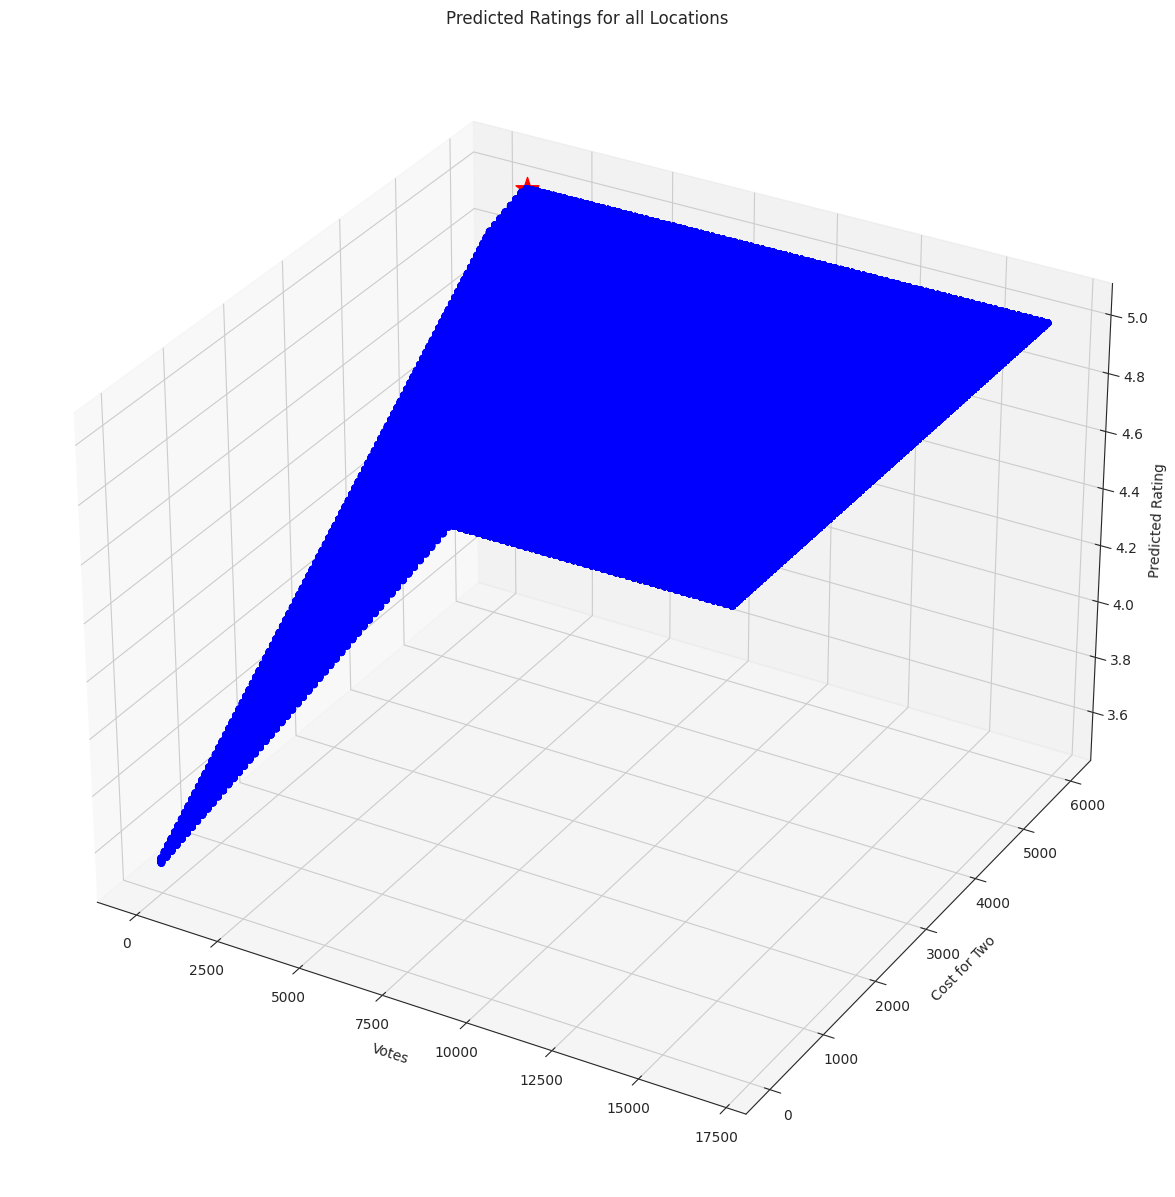

In [301]:
(acc, votes,cost_for_2,predicted_rating) = recommend_location(zomato_en)

In [302]:
print("Linear Regression results:\n")
print(acc)
print("Votes:", votes)
print("Cost for two people:",cost_for_2)
print("Predicted rating:", predicted_rating)

Linear Regression results:

Model accuracy: MSE = 0.11994468835726683, R-squared = 0.23422790109697322
Votes: 1178.24
Cost for two people: 6000.0
Predicted rating: 5.0


In [303]:
print("Recommended location for opening a new restaurant from linear regression model:")
data[data['cost for two'] == cost_for_2]['city'].unique()[0]

Recommended location for opening a new restaurant from linear regression model:


'Indiranagar'

In [371]:
#2 Logistic Regression

def recommend_location(df):
  X = df[['votes', 'cost for two', 'location']].values
  y = (df['rate'] >= 4.0).astype(int).values
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  model = LogisticRegression()
  model.fit(X_train, y_train)

  y_pred = model.predict(X_test)
  acc = accuracy_score(y_test, y_pred)

  max_votes = df['votes'].max()
  max_cost = df['cost for two'].max()
  locations = df['location'].unique()
  possible_votes = np.linspace(0, max_votes, 101)
  possible_cost = np.linspace(0, max_cost, 101)
  possible_locations = [(votes, cost, loc) for votes in possible_votes for cost in possible_cost for loc in locations]
  new_df = pd.DataFrame(possible_locations, columns=['votes', 'cost for two', 'location'])

  y_pred_prob = model.predict_proba(new_df[['votes', 'cost for two', 'location']].values)[:,1]

  new_df['predicted probability'] = y_pred_prob

  best_location = new_df.loc[new_df['predicted probability'].idxmax()]

  # Visualization
  plt.figure(figsize=(10, 8))
  heatmap_data = pd.pivot_table(new_df, values='predicted probability', 
                                 index=['votes'], columns=['cost for two'])
  sns.heatmap(heatmap_data, cmap="coolwarm")
  plt.xlabel('Cost for two')
  plt.ylabel('Votes')
  plt.title('Predicted Probability of Restaurant Success')
  plt.scatter(best_location[1]/max_cost*100, best_location[0]/max_votes*100, 
              s=200, marker='X', color='black')
  plt.show()

  return ("Model accuracy: Accuracy score = {}".format(acc), best_location['votes'], best_location['cost for two'], best_location['predicted probability'])

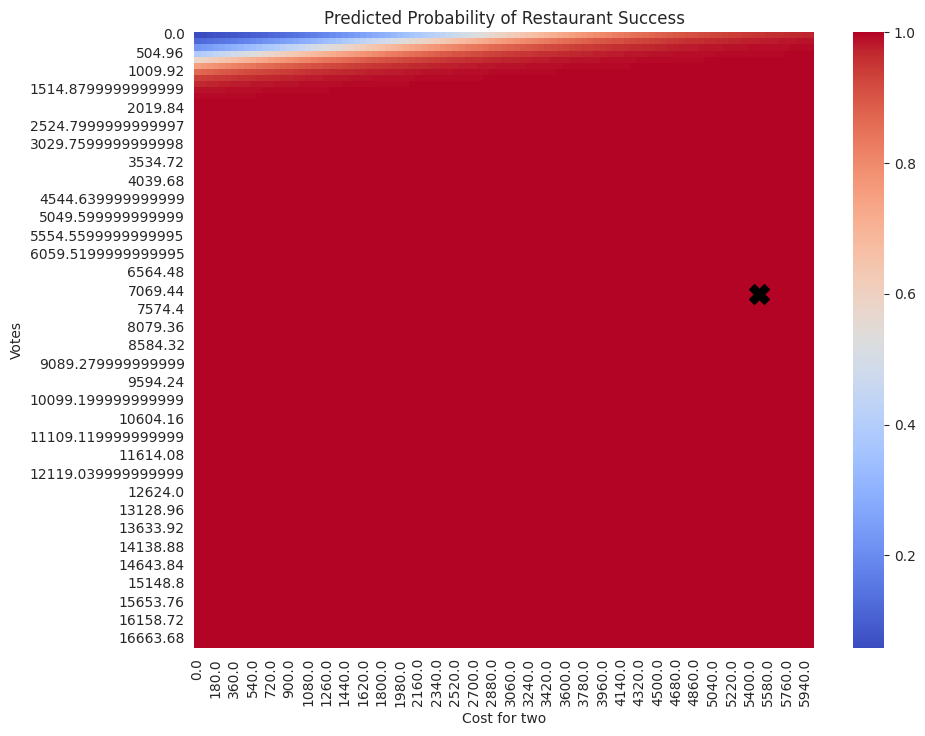

In [305]:
(acc, votes,cost_for_2,predicted_rating) = recommend_location(zomato_en)

In [306]:
print("Logistic Regression results:\n")
print(acc)
print("Votes:", votes)
print("Cost for two people:",cost_for_2)
print("Predicted Probability of success:", predicted_rating)

Logistic Regression results:

Model accuracy: Accuracy score = 0.8589896579156723
Votes: 7237.759999999999
Cost for two people: 5520.0
Predicted Probability of success: 1.0


In [307]:
print("Recommended location for opening a new restaurant from logistic regression model:")
data[data['cost for two'] == find_nearest_cost(data,cost_for_2)]['city'].unique()[0]

Recommended location for opening a new restaurant from logistic regression model:


'Indiranagar'

In [308]:
#3 KNN 

def recommend_location(df):
  X = df[['votes', 'cost for two']].values
  y = (df['rate'] >= 4.0).astype(int).values 
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  model = KNeighborsClassifier(n_neighbors=5)
  model.fit(X_train, y_train)

  y_pred = model.predict(X_test)

  accuracy = accuracy_score(y_test, y_pred)

  max_votes = df['votes'].max()
  max_cost = df['cost for two'].max()
  possible_votes = np.linspace(0, max_votes, 101)
  possible_cost = np.linspace(0, max_cost, 101)
  possible_locations = [(votes, cost) for votes in possible_votes for cost in possible_cost]
  new_df = pd.DataFrame(possible_locations, columns=['votes', 'cost for two'])

  y_pred_prob = model.predict_proba(new_df[['votes', 'cost for two']].values)[:,1]

  # location with the highest predicted probability of success
  new_df['predicted probability'] = y_pred_prob
  best_location = new_df.loc[new_df['predicted probability'].idxmax()]

  # visualisation
  plt.figure(figsize=(10, 8))
  plt.scatter(new_df['votes'], new_df['cost for two'], c=new_df['predicted probability'])
  plt.colorbar()
  plt.xlabel('Votes')
  plt.ylabel('Cost for two')
  plt.title('Success Probabilty of Restaurants in Bangalore')
  plt.scatter(best_location[0], best_location[1], c='red', marker='X')
  plt.xlim(0, 5000)
  plt.ylim(0, 10000)
  plt.show()
  
  return (f"Model accuracy: {accuracy}", best_location['votes'], best_location['cost for two'], best_location['predicted probability'])

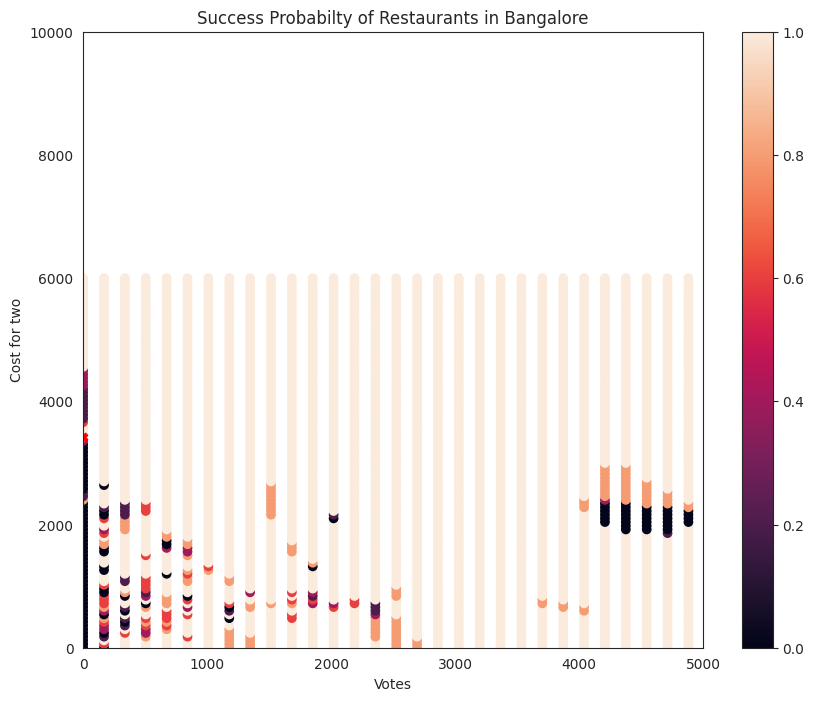

In [309]:
(acc, votes,cost_for_2,predicted_rating) = recommend_location(zomato_en)

In [310]:
print("KNN results:\n")
print(acc)
print("Votes:", votes)
print("Cost for two people:",cost_for_2)
print("Predicted Probability of success:", predicted_rating)

KNN results:

Model accuracy: 0.9120922832140016
Votes: 0.0
Cost for two people: 3420.0
Predicted Probability of success: 1.0


In [311]:
print("Recommended location for opening a new restaurant from KNN model:")
data[data['cost for two'] == find_nearest_cost(data,cost_for_2)]['city'].unique()[0]

Recommended location for opening a new restaurant from KNN model:


'Brigade Road'

In [321]:
# 4: Matrix factorization
def recommend_location(cuisine, df):
    filtered_df = df[df['cuisines'].str.contains(cuisine, na=False)]
    
    pivot_table = pd.pivot_table(filtered_df, values='rate', index='location', aggfunc=np.mean)
    locations = list(pivot_table.index)
    n_users = len(pivot_table)
    n_locations = len(locations)
    
    location_to_index = {location: index for index, location in enumerate(locations)}
    index_to_location = {index: location for index, location in enumerate(locations)}
    
    ratings_matrix = np.zeros((n_users, n_locations))
    for location, row in pivot_table.iterrows():
        location_index = location_to_index[location]
        ratings_matrix[:, location_index] = row.values.reshape(1, -1)
    
    X_train, X_test, y_train, y_test = train_test_split(ratings_matrix, ratings_matrix, test_size=0.2, random_state=42)
    
    input_layer = Input(shape=(n_locations,))
    embedding_layer = Embedding(n_locations, 10)(input_layer)
    flatten_layer = Flatten()(embedding_layer)
    output_layer = Dense(n_locations, activation='linear')(flatten_layer)
    model = Model(inputs=input_layer, outputs=output_layer)
    
    optimizer = Adam(lr=0.001)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    history = model.fit(X_train, y_train, batch_size=64, epochs=20, verbose=0, validation_data=(X_test, y_test))
    
    mse = model.evaluate(X_test, y_test)
    
    location_embeddings = model.layers[1].get_weights()[0]
    
    cosine_similarities = cosine_similarity(location_embeddings)
    
    fig, ax = plt.subplots(figsize=(30, 30))
    sns.heatmap(cosine_similarities, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1, ax=ax, annot_kws={"size": 10})
    ax.set_title('Pairwise Cosine Similarities between Locations')
    ax.set_xlabel('Location')
    ax.set_ylabel('Location')
    ax.set_xticks(np.arange(0.5, len(locations), 1))
    ax.set_yticks(np.arange(0.5, len(locations), 1))
    ax.set_xticklabels(locations, rotation=90, ha='right')
    ax.set_yticklabels(locations, rotation=0)
    plt.tight_layout()
    plt.show()
    
    # location with the highest similarity score
    best_location_index = np.argmax(cosine_similarities.sum(axis=1))
    best_location_name = index_to_location[best_location_index]
   
    return f"Mean Squared Error: {mse}", best_location_name, cosine_similarities.max()

/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



1/1 [==============================] - 0s 116ms/step - loss: 12.3969


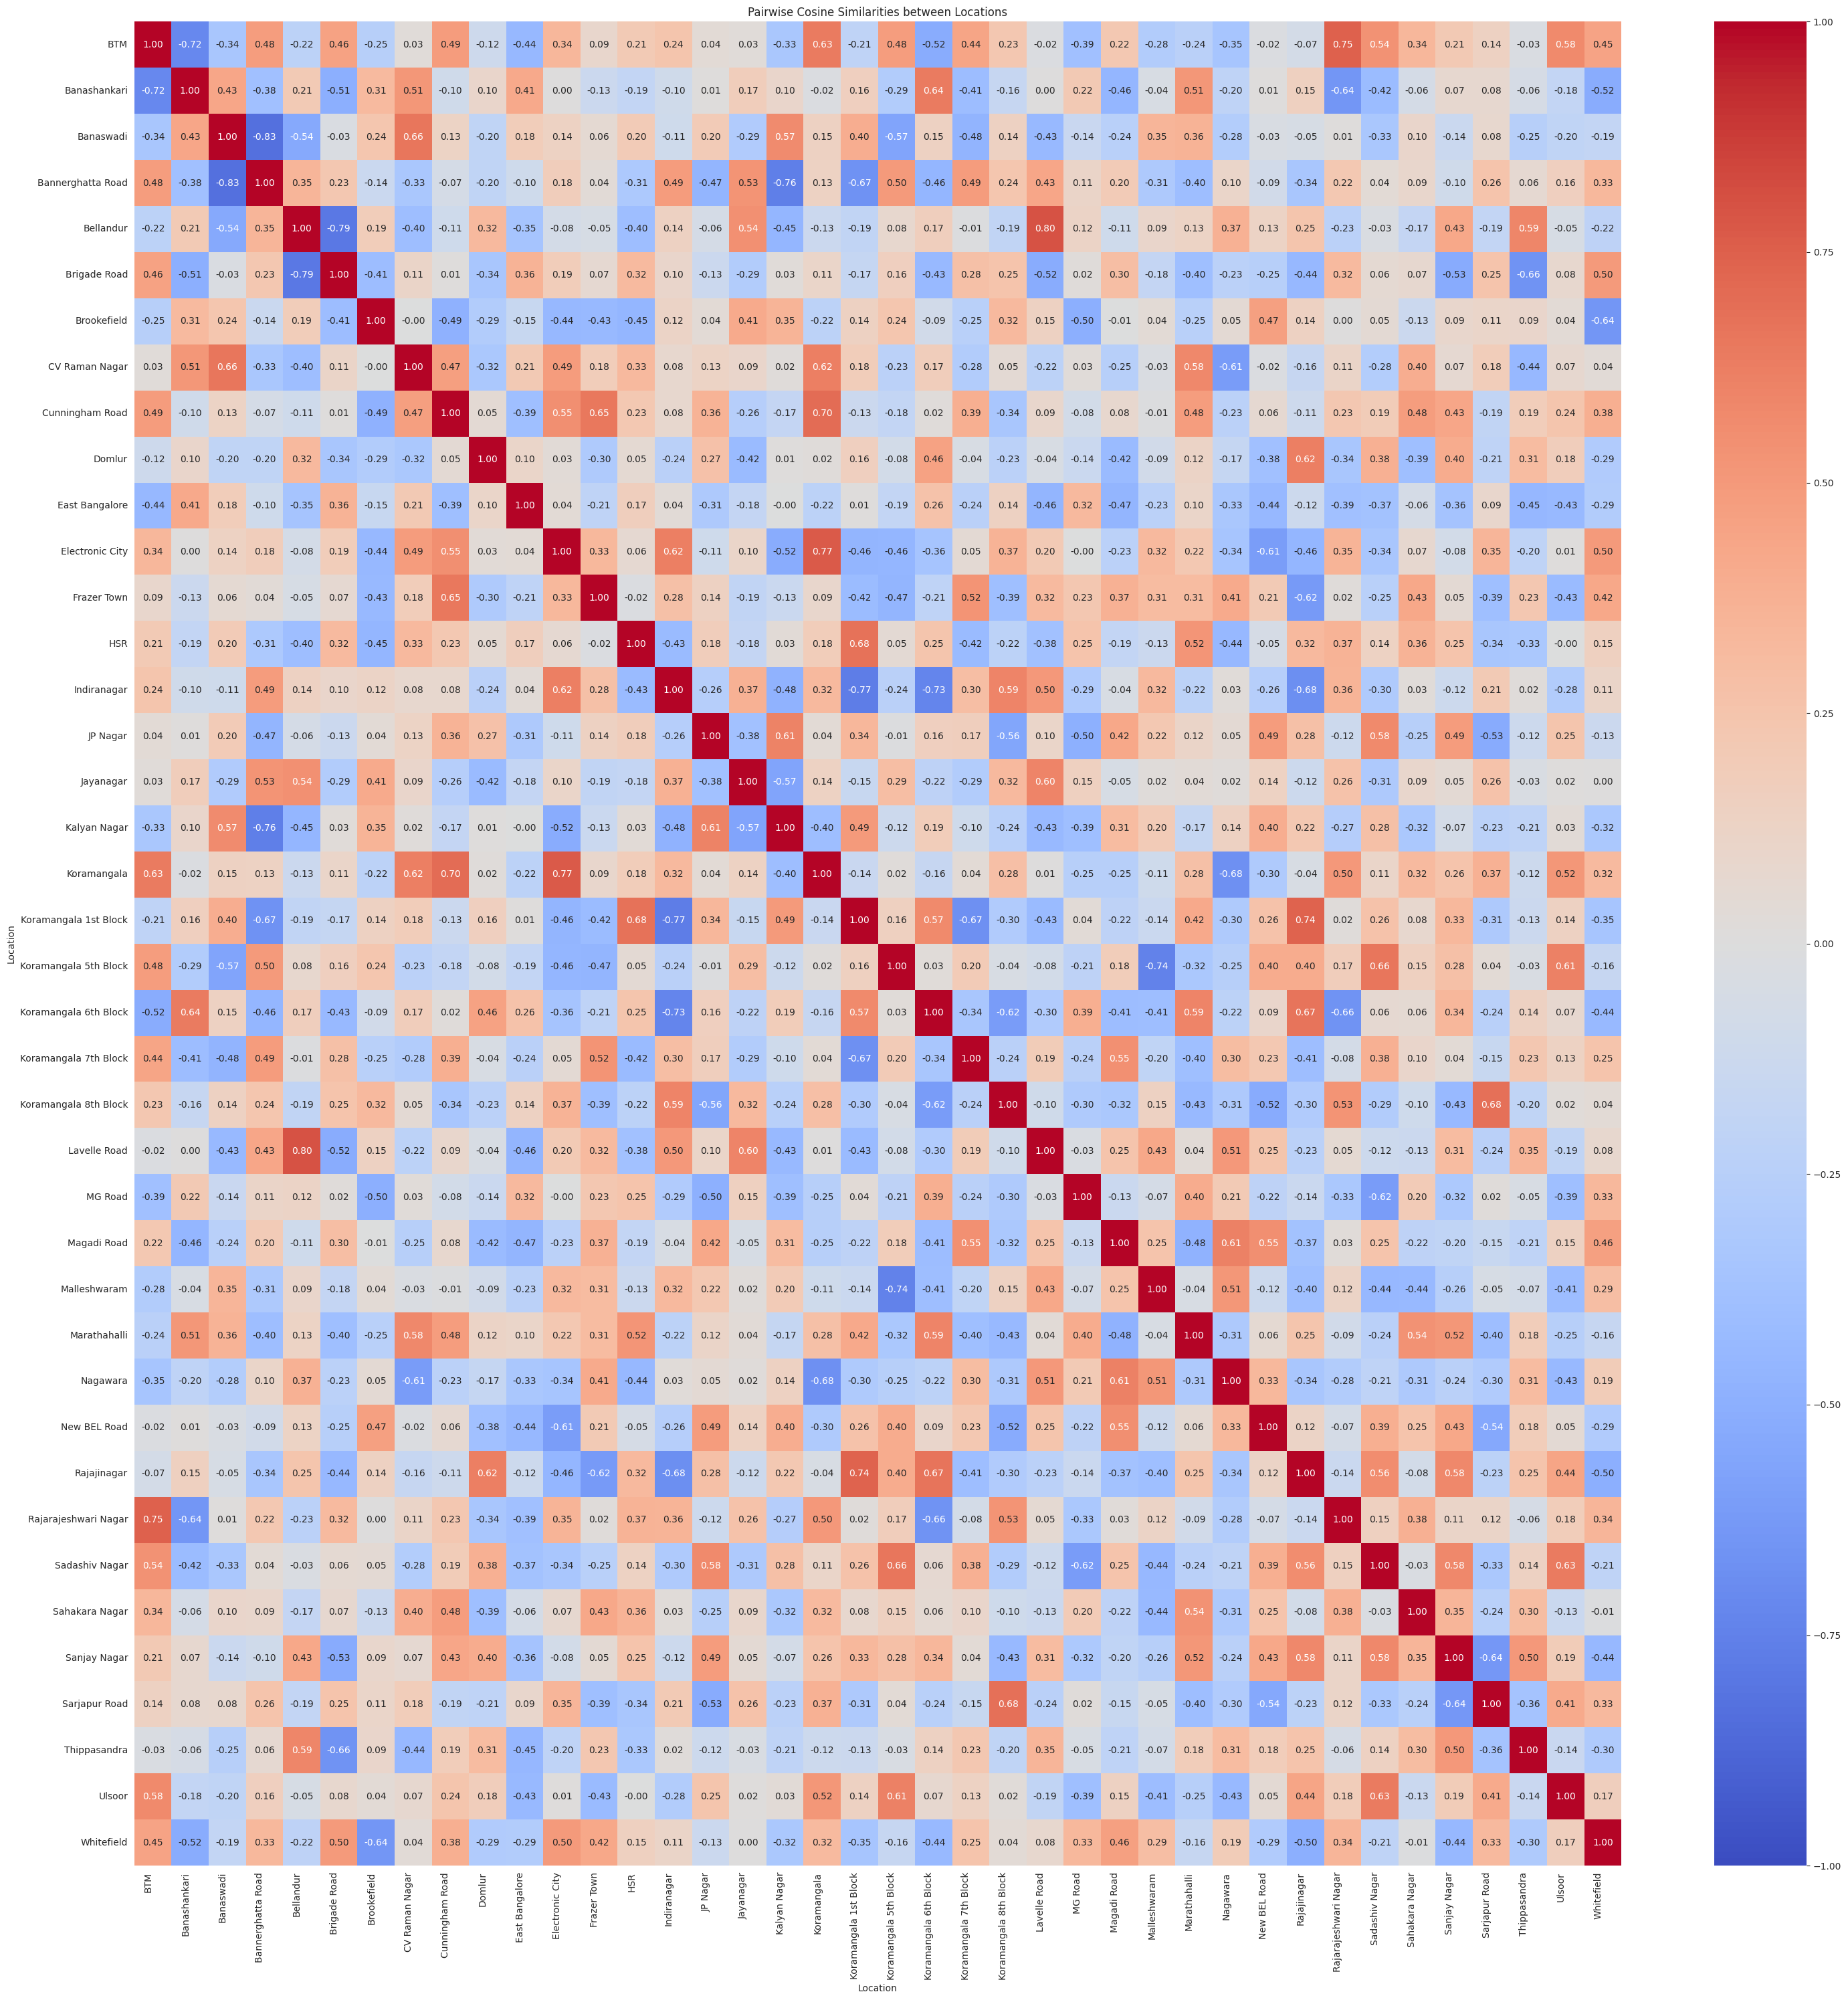

In [323]:
# determine the best location for Mexican cuisine
(acc, loc, similarity_score) = recommend_location('Mexican', data)

In [324]:
print("Matrix factorization results:\n")
print(acc)
print("Similarity score:", similarity_score)

Matrix factorization results:

Mean Squared Error: 12.396944999694824
Similarity score: 1.0000001


In [325]:
print("Recommended location for opening a new restaurant for Mexican cuisine from Matrix factorization:\n", loc)

Recommended location for opening a new restaurant for Mexican cuisine from Matrix factorization:
 Cunningham Road


In [331]:
#5 Random Forest Classifier

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def recommend_location(df):

  X = df[['votes', 'cost for two']].values
  y = (df['rate'] >= 4.0).astype(int).values 
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  model = RandomForestClassifier(n_estimators=100, random_state=42)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)
  max_votes = df['votes'].max()
  max_cost = df['cost for two'].max()
  possible_votes = np.linspace(0, max_votes, 101)
  possible_cost = np.linspace(0, max_cost, 101)
  possible_locations = [(votes, cost) for votes in possible_votes for cost in possible_cost]
  new_df = pd.DataFrame(possible_locations, columns=['votes', 'cost for two'])

  fig = plt.figure(figsize=(15,15))
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(df['votes'], df['cost for two'], df['rate'], c=y, cmap='viridis')
  ax.set_xlabel('Votes')
  ax.set_ylabel('Cost for two')
  ax.set_zlabel('Rating')
  ax.set_title('Restaurant Ratings')
    
  plt.show()
  
  y_pred_prob = model.predict_proba(new_df[['votes', 'cost for two']].values)[:,1] 

  new_df['predicted probability'] = y_pred_prob
  best_location = new_df.loc[new_df['predicted probability'].idxmax()]
  
  return (f"Model accuracy: {accuracy}", best_location['votes'], best_location['cost for two'], best_location['predicted probability'])

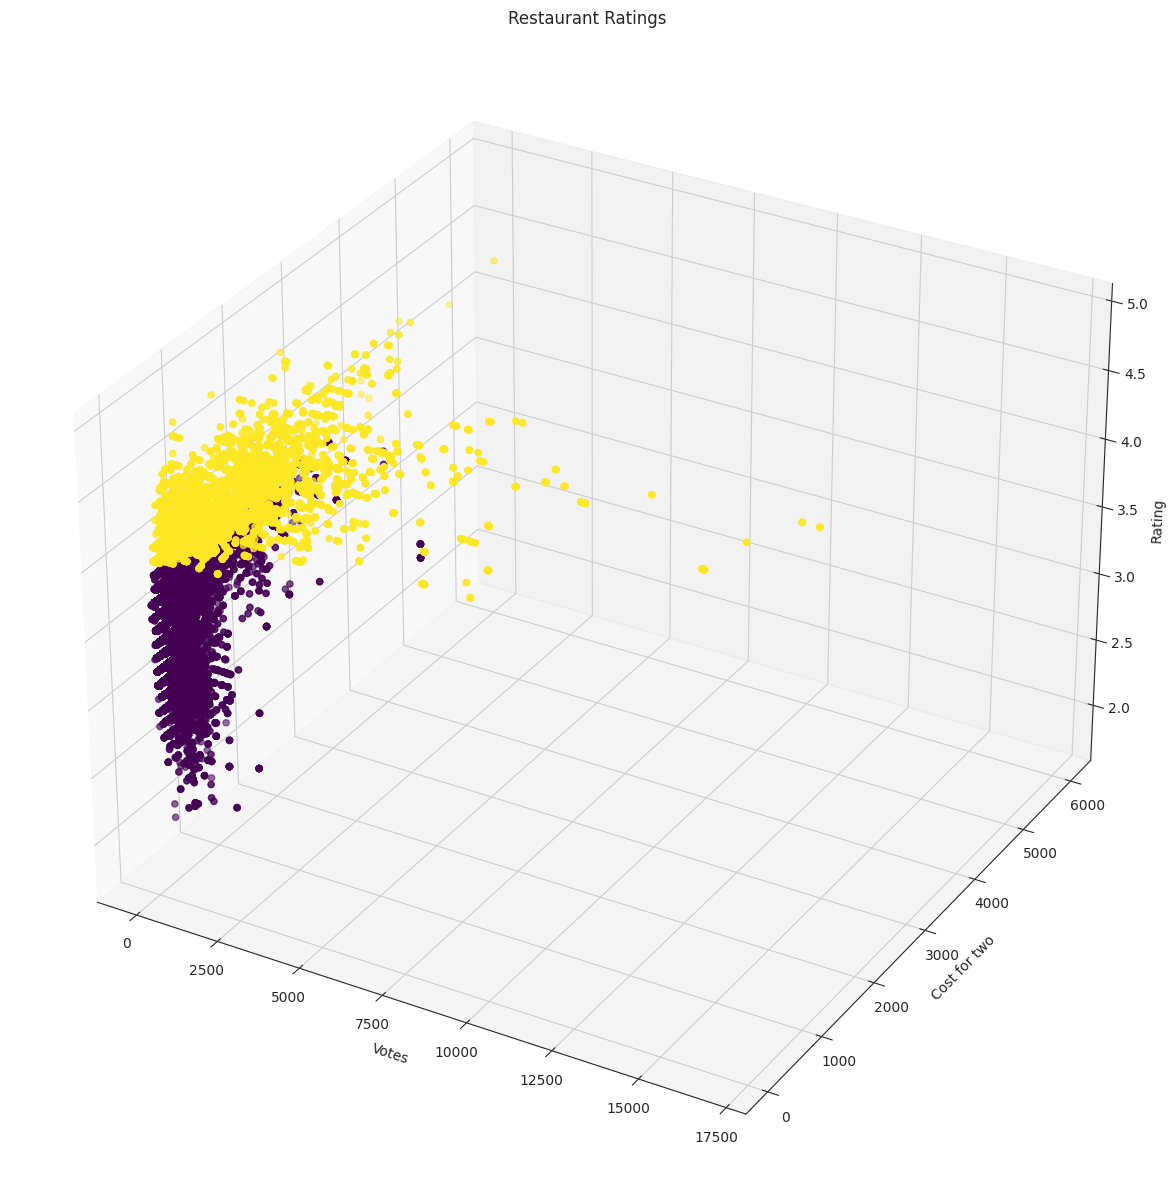

In [332]:
acc, votes, cost_for_2, success_probability = recommend_location(data)

In [318]:
print("Random Forest Classifier results:\n")
print(acc)
print("Votes:", votes)
print("Cost for two people:",cost_for_2)
print("Predicted Probability of success:", success_probability)

Random Forest Classifier results:

Model accuracy: 0.927903739061257
Votes: 168.32
Cost for two people: 2400.0
Predicted Probability of success: 1.0


In [319]:
print("Recommended location for opening a new restaurant for North Indian cuisine from Random Forest Classifier :")
data[data['cost for two'] == find_nearest_cost(data,cost_for_2)]['city'].unique()[0]

Recommended location for opening a new restaurant for North Indian cuisine from Random Forest Classifier :


'Brigade Road'

50279it [01:02, 806.15it/s] 


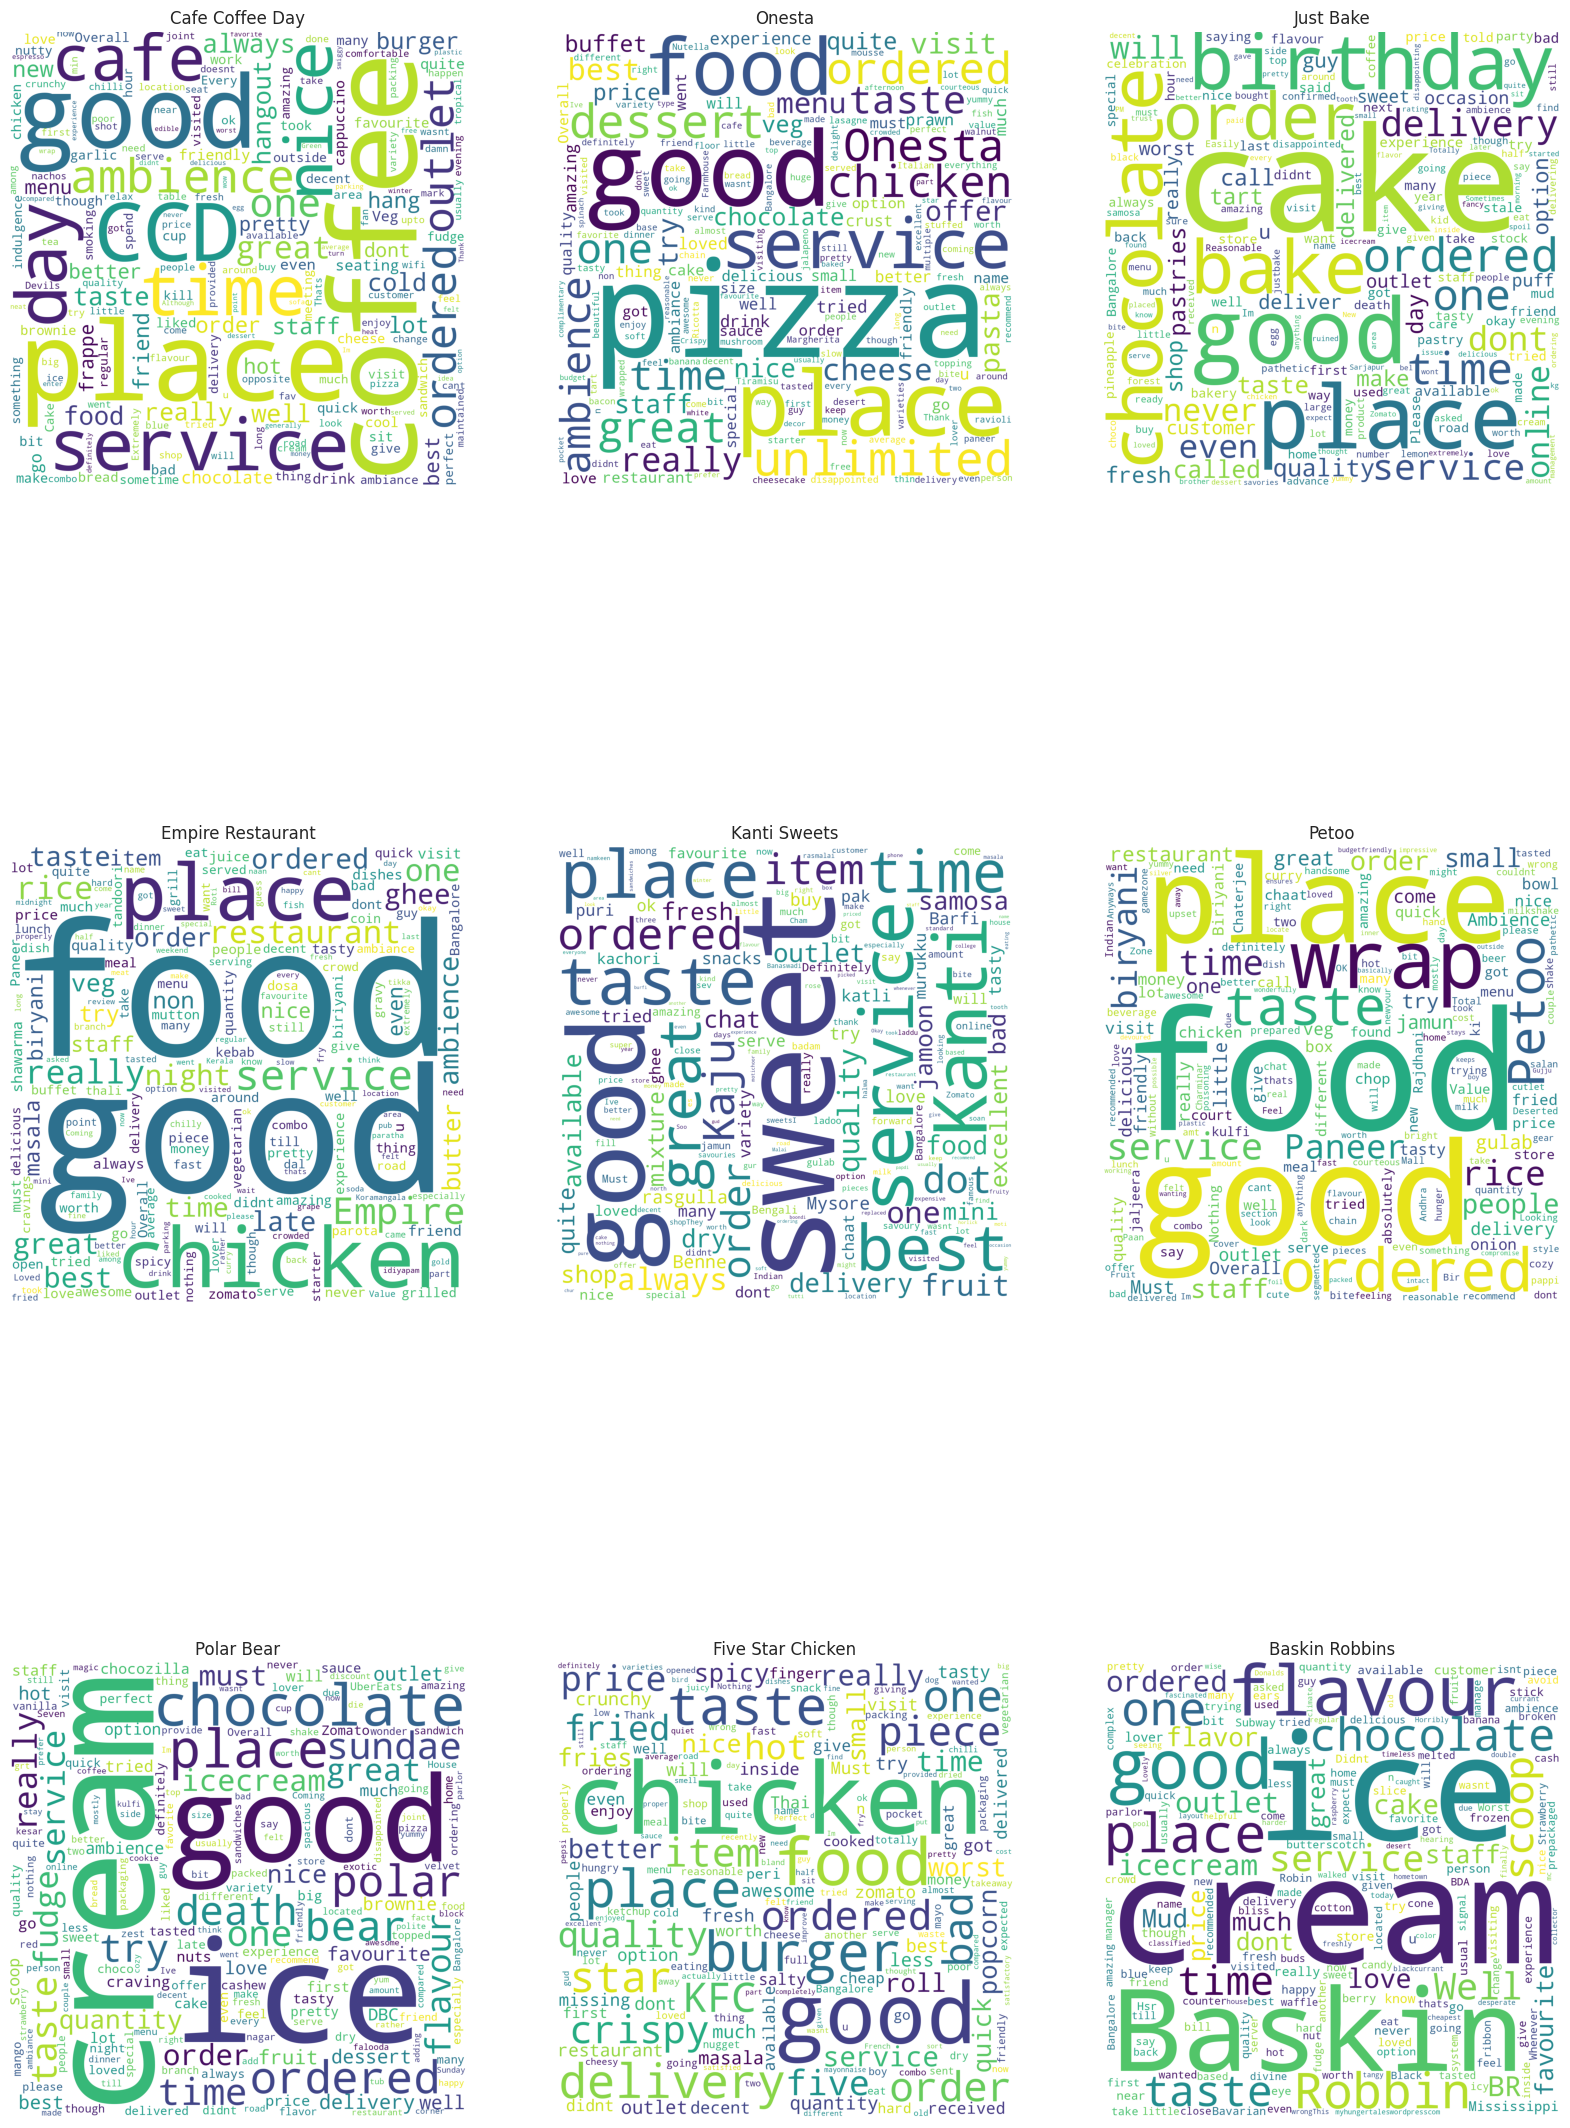

In [360]:
#6 Bag of Words

all_ratings = []
for name, reviews_list in tqdm(zip(data['name'], data['reviews_list'])):
    # converting the reviews from string to a list of tuples
    reviews = eval(reviews_list)
    for score, doc in reviews:
        if score:
            # Strip the 'Rated' and 'RATED' prefix 
            # and any leading/trailing whitespaces from the score
            score = score.strip("Rated").strip()
            doc = doc.strip('RATED').strip()
            score = float(score)
            all_ratings.append([name, score, doc])

# dataframe to store the ratings
rating_df = pd.DataFrame(all_ratings, columns=['name', 'rating', 'review'])
# removing special characters from the reviews
rating_df['review'] = rating_df['review'].apply(lambda x: re.sub('[^a-zA-Z0-9\s]', "", x))
rating_df.to_csv('Ratings.csv')

# top 9 most reviewed restaurants
top_restaurants = data['name'].value_counts()[:9].index

# create word clouds for each restaurant
def produce_wordcloud(restaurants):
    # figure with 9 subplots
    plt.figure(figsize=(20, 30))
    for i, restaurant in enumerate(restaurants):
        plt.subplot(3, 3, i+1)
        # reviews for the current restaurant
        corpus = rating_df[rating_df['name'] == restaurant]['review'].values.tolist()
        # get the reviews into a single string
        corpus = ' '.join(x for x in corpus)
        wordcloud = WordCloud(max_font_size=None, background_color='white', collocations=False,
                      width=1500, height=1500).generate(corpus)
        # displaying the word cloud
        plt.imshow(wordcloud)
        plt.title(restaurant)
        plt.axis("off")

# word clouds for the top 9 restaurants
produce_wordcloud(top_restaurants)

In [370]:
# Filter the data based on the top restaurants
top_restaurant_data = data[data['name'].isin(top_restaurants)]

all_ratings = []
for name, reviews_list, cuisines in tqdm(zip(top_restaurant_data['name'], top_restaurant_data['reviews_list'], top_restaurant_data['cuisines'])):
    reviews = eval(reviews_list)

    for score, doc in reviews:
        if score:
            score = score.strip("Rated").strip()
            doc = doc.strip('RATED').strip()
            score = float(score)
            all_ratings.append([name, score, doc, cuisines])

rating_df = pd.DataFrame(all_ratings, columns=['name', 'rating', 'review', 'cuisines'])
rating_df['review'] = rating_df['review'].apply(lambda x: re.sub('[^a-zA-Z0-9\s]', "", x))
rating_df.to_csv('Ratings.csv')

cuisine_ratings = rating_df.groupby('cuisines')['rating'].mean().reset_index()

sorted_cuisine_ratings = cuisine_ratings.sort_values('rating', ascending=False)

print(sorted_cuisine_ratings)

# select the top cuisine
top_cuisine = sorted_cuisine_ratings.iloc[0]['cuisines']
print('\nThe most popular cuisines among the top restaurants is:', top_cuisine)

645it [00:01, 358.95it/s]


                                             cuisines    rating
4       Burger, Fast Food, Roast Chicken, Finger Food  4.666667
7                                 Desserts, Ice Cream  4.364865
17                            North Indian, Fast Food  4.000000
15                                Mithai, Street Food  3.992138
8            Desserts, Ice Cream, Beverages, Sandwich  3.955556
22                               Pizza, Cafe, Italian  3.922348
13           Ice Cream, Desserts, Beverages, Sandwich  3.819853
11                                          Ice Cream  3.661058
18               North Indian, Fast Food, Street Food  3.566489
2   Biryani, Kerala, Mughlai, Arabian, North India...  3.555556
20                         North Indian, South Indian  3.500000
21                 North Indian, South Indian, Kerala  3.500000
3                       Biryani, North Indian, Andhra  3.500000
19       North Indian, Mughlai, South Indian, Chinese  3.494050
10                                  Fast